<a href="https://colab.research.google.com/github/AissatouPaye/AnomalyDetection.jl/blob/master/GAN_based_for_Anomalies_Detection_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AnoGAN and F-AnoGAN


Use the MNIST Dataset to see how AnoGAN and F-AnoGAN works as Anomalies detector



*   1 has normal image
*   7 has anomalious image




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import argparse


### use MNIST dataset for the GAN models

from keras .datasets import mnist 

from keras.models import Sequential,Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose
from keras.layers import Lambda
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import math

from keras.utils. generic_utils import Progbar
from keras.utils.vis_utils import plot_model

from typing import Tuple
from keras.models import load_model
from keras import backend as K
from sklearn.manifold import TSNE
from keras.layers import concatenate

# Google Colab
from google.colab import drive

from sklearn.manifold import TSNE
import copy
from enum import Enum

from keras.callbacks import TensorBoard
import io
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from math import floor
from skimage.transform import resize
from scipy.linalg import sqrtm

Using TensorFlow backend.


MNIST DATASET

Download the data and create a traning and test loader


In [0]:
#####Setting the general parameter that will be use to save the models results ###

class DataParm(Enum):
    image_size_127_5 = 127.5
    # VAE Path to save  models, images, and Tensorboard logs
    common_path_VAE = '/content/drive/My Drive/AnoDetect_implementation/VAE/'
    ##### Path AnoGAN
    common_path = '/content/drive/My Drive/AnoDetect_implementation/AnoGAN/'
    # EfficentAnnoGAN: Path to store the model, images, and Tensorboard logs
    common_path_f_AnoGAN = '/content/drive/My Drive/AnoDetect_implementation/f-AnoGAN/'
    batch_size_64 = 64

In [4]:

# Train and test data

(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
### Convert image scale to -1 to 1 ####


image_size= X_train.shape[1]
original_dim = image_size*image_size
input_shape= (image_size,image_size,1)


X_train=(X_train.astype(np.float32)- image_size)/image_size
X_test=(X_test.astype(np.float32)- image_size)/image_size

#### Convert to batch size, width, height, channel ####
X_train=X_train[:,:,:,None]
X_test=X_test[:,:,:,None]

# Keep as original image
X_test_original = X_test.copy()

#Learn only image with labe 1 ( our positif sample that the generative model have to learn)

X_train=X_train[Y_train==1]
X_test=X_test[Y_test==1]

11493376/11490434 [==============================] - 2s 0us/step


In [5]:

X_train[0].shape


### visualize one sample of the data : showing a 1 of the training set ####



(28, 28, 1)

## AnoGAN


<img src = "/content/AnoGAN.jpg">

## Generator












Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64) 

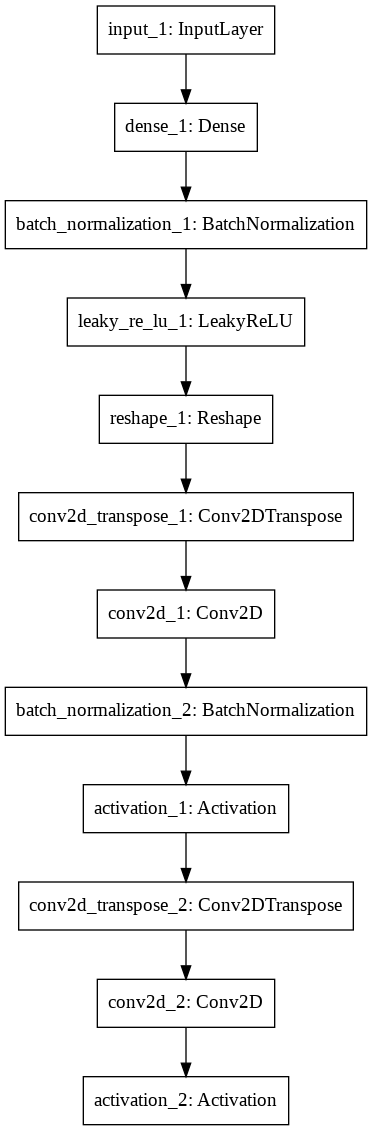

In [6]:
class GeneratorParam(Enum):
    units_128_7_7 = 128*7*7
    leaky_relu_param_0_2 = 0.2
    reshape_size_7_7_128 = (7, 7, 128)
    
    conv2d_transpose_filter_64 = 64
    conv2d_transpose_kernel_2_2 = (2, 2)
    conv2d_transpose_stride_2_2 = (2, 2)
    
    conv2d_filter_64 = 64
    conv2d_kernel_3_3 = (3, 3)
    conv2d_padding_same = 'same'
    
    activation_relu = 'relu'
    
    conv2d_out_filter_1 = 1
    conv2d_out_kernel_5_5 = (5, 5)
    out_activation_tanh = 'tanh'
    

def generator_model(in_shape: tuple=(10,)) -> Model:
    """
    Parameters
    ----------
    in_shape : tuple
        Dimension of noise space
    
    Returns
    -------
    model: Model
    """
    inputs = Input(in_shape)
    fc1 = Dense(input_dim=in_shape[0], units=GeneratorParam.units_128_7_7.value)(inputs)
    # to stabilize the learning
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(GeneratorParam.leaky_relu_param_0_2.value)(fc1)
    # Processing to convert to image  of size 7x7 
    fc2 = Reshape(GeneratorParam.reshape_size_7_7_128.value, input_shape=(GeneratorParam.units_128_7_7.value,))(fc1)
    # Convert to image of size 14x14
    up1 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value, 
                          GeneratorParam.conv2d_transpose_kernel_2_2.value, 
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value, 
                          padding=GeneratorParam.conv2d_padding_same.value)(fc2)
    conv1 = Conv2D(GeneratorParam.conv2d_filter_64.value, 
                   GeneratorParam.conv2d_kernel_3_3.value, 
                   padding=GeneratorParam.conv2d_padding_same.value)(up1)
    # to stabilize the learning too
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(GeneratorParam.activation_relu.value)(conv1)
    # convert to image f size 28x28
    up2 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value, 
                          GeneratorParam.conv2d_transpose_kernel_2_2.value, 
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value, 
                          padding=GeneratorParam.conv2d_padding_same.value)(conv1)
    # convert back to black an white image with 1 channel
    conv2 = Conv2D(GeneratorParam.conv2d_out_filter_1.value, 
                   GeneratorParam.conv2d_out_kernel_5_5.value, 
                   padding=GeneratorParam.conv2d_padding_same.value)(up2)
    outputs = Activation(GeneratorParam.out_activation_tanh.value)(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
  
g_model = generator_model()
g_model.summary()
plot_model(g_model, to_file='g_model.png')

In [0]:
# import keras
# keras.__version__

## Discriminator

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273

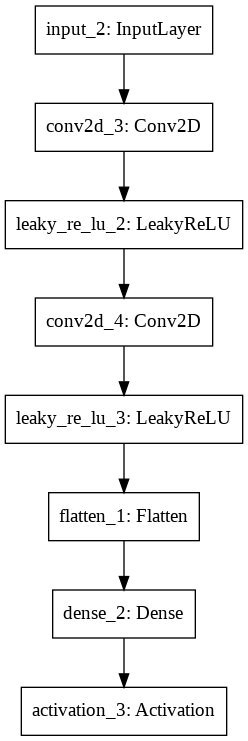

In [8]:
class DiscriminatorParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_5_5 = (5, 5)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    leaky_reLU_param_0_2 = 0.2
    
    conv2d_second_filter_128 = 128
    conv2d_second_kernel_5_5 = (5, 5)
    conv2d_second_stride_2_2 = (2, 2)
    conv2d_second_padding_same = 'same'
    
    dense_1 = 1
    
    out_activation_sigmoid = 'sigmoid'
    
    
def discriminator_model(image_shape: tuple=(28, 28, 1)) -> Model:
    """
    
    Parameters
    ----------
    image_shape : tuple
    
    Returns
    -------
    model: Model
    """
    inputs = Input(image_shape)
    # Change image to 14x14x64 feature map
    conv1 = Conv2D(DiscriminatorParam.conv2d_filter_64.value, 
                   DiscriminatorParam.conv2d_kernel_5_5.value, 
                   strides=DiscriminatorParam.conv2d_stride_2_2.value, 
                   padding=DiscriminatorParam.conv2d_padding_same.value)(inputs)
    conv1 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv1)
    # Change image to 7x7x18 feature map
    conv2 = Conv2D(DiscriminatorParam.conv2d_second_filter_128.value, 
                   DiscriminatorParam.conv2d_second_kernel_5_5.value,
                   strides=DiscriminatorParam.conv2d_second_stride_2_2.value, 
                   padding=DiscriminatorParam.conv2d_second_padding_same.value)(conv1)
    conv2 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv2)
    fc1 = Flatten()(conv2)
    # 1 class output for fake and real classification
    fc1 = Dense(DiscriminatorParam.dense_1.value)(fc1)
    outputs = Activation(DiscriminatorParam.out_activation_sigmoid.value)(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
  
d_model = discriminator_model()
d_model.summary()
plot_model(d_model, to_file='d_model.png')

## Genrator containing Discriminator

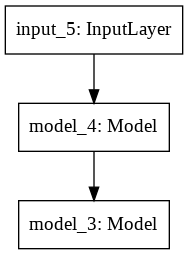

In [9]:
def generator_containint_discriminator(g: Model, d: Model, in_shape: tuple=(10,)) -> Model:
    """
    DiscriminatorとGeneratorモデルの合成
    
    Parameters
    ----------
    g : Generator Model
        
    d : Discriminator Model
     
    
    Returns
    -------
    gan : A mixed model for learning only a generated model without learning an identification Model
        
    """
    # Generator setting for learning
    d.trainable = False
    # setting for adding noise
    ganInput = Input(shape=in_shape)
    # input noise into the generator
    x = g(ganInput)
    # Enter the generated image into the discriminator
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    return gan

d_model = discriminator_model()
g_model = generator_model()
g_d_model = generator_containint_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')

### Combining the images

In [0]:
def combine_images(generated_images: np.ndarray) -> np.ndarray:
    """
    Synthethize the generated image to check the learning progress
    
    Parameters
    ----------
    generated_images : np.ndarray , image generated for batch size
    

    Returns
    -------
    image: np.ndarray , Combine generated images and modify them into one large image
        
    """
    # number of generated images
    num = generated_images.shape[0]
    # generated image width
    width = int(math.sqrt(num))
    # generated image height
    heigh = int(math.ceil(float(num) / width))
    #Get the height, width and number of channels of the generated image
    shape = generated_images.shape[1:4]
    # Scale height and width
    image = np.zeros((heigh * shape[0], width*shape[1], shape[2]), dtype=generated_images.dtype)
    # Processing to embed each generated image data in one large image data
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]: (i+1) * shape[0], j * shape[1]:(j + 1) * shape[1], :] = img[:, :, :]
    return image

### Load the Model

In [0]:
def load_models(common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
    Load learned generation model and identification model (pretrained)
    Parameters
    ----------
    common_path : str
    Specify path to load model

    Returns
    -------
    g: Generative Model
        
    d: discriminative Model
      
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    return g, d

### Tensorboard

Setting of log file that will be use to get performance

In [0]:
def write_log(callback, names, logs, epoch):
    """
    Tensorboard : save the loss to
    
    Parameters
    ----------
    callback: Set Tensorboard for Callback function
        
    names: str ,Set name of log to save
        
    logs:  Set the value to save
        
    epoch: set number

    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, epoch)
        callback.writer.flush()
        

log_path = DataParm.common_path.value + '/logs'
callback = TensorBoard(log_path)

## Metrics for Generated images Inception



### Calculate Inception Score

Calculate image quality and diversity

In [13]:
def scale_images(images: np.asarray, new_shape: tuple) -> np.asarray:
    """
    
    Parameters
    
    Change the size of the image (change to a size that can be inferred by Inception Model)
    ----------
    images: np.asarray ,Batch size image data
        
    new_shape: tuple ,The size of the image you want to change
      
    Returns
    -------
       List of resized images
    """
    images_list = list()
    for image in images:
        # Change image size
        new_image = resize(image, new_shape, 0)
        # Keep resized images in list
        images_list.append(new_image)
    return np.array(images_list)


def calculate_inception_score(images: np.asarray, model: Model=InceptionV3(), n_split: int=10, eps: float=1E-16) -> Tuple[np.asarray, np.asarray]:
    """
  
    Parameters
    
    Calculate mean and standard deviation of Inception Score
    ----------
    images: np.asarray ,Multiple image data
        
    model: Model to infer from
      
    n_split: int,Number of groups for dividing multiple image data into groups
       
    eps: float ,Add a value so that it does not become 0 when calculating logarithm
        
    Returns
        is_avg: float ,Inception Score average
           
        is_std: float ,Inception Score standard deviation
            
    -------
    """
    scores = list()
    # Calculate number of groups
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # Acquire images by group
        # 
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert to float32
        subset = subset.astype("float32")
        # Change to size that can be inferred with Inception Model
        subset = scale_images(subset, (299, 299, 3))
        # Preprocess to [-1,1]
        subset = preprocess_input(subset)
        # Infer p (y | x)
        p_yx = model.predict(subset)
        # Infer p (y) for each class
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        # Logarithmic probability KL divergence calculation
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # Sum of KL divergence for each class
        sum_kl_d = kl_d.sum(axis=1)
        # KL divergence average
        avg_kl_d = np.mean(sum_kl_d)
        # Return KL divergence from logarithmic domain
        is_score = np.exp(avg_kl_d)
        # save in list
        scores.append(is_score)
    # Calculate mean and standard deviation
    is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std



96116736/96112376 [==============================] - 8s 0us/step


### FID calculation

FID is a measure of similarity between two datasets of images. It was shown to correlate well with human judgement of visual quality and is most often used to evaluate the quality of samples of Generative Adversarial Networks.

We then calculate distance to actual image by using a pretrained image recognition model Inception (pre-trained Inception-v3 model achieves state-of-the-art accuracy for recognizing general objects with 1000 classes)

In [14]:
def calculate_fid(real_images: np.asarray, generate_images: np.asarray, model: Model=InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))) -> float:
    """
    Parameters:  Calculate FID
 
    ----------
    real_images: np.asarray
        Set multiple real images
    generate_images: np.asarray
        Set multiple generated images
    model: Model
        Set feature extraction model
    Returns
        fid: float
        Calculate FID
    -------
    """
    # Change to inferable float32
    real_images = real_images.astype("float32")
    generate_images = generate_images.astype("float32")
    # Change image size
    real_images = scale_images(real_images, (299, 299, 3))
    generate_images = scale_images(generate_images, (299, 299, 3))
    # Image preprocessing
    real_images = preprocess_input(real_images)
    generate_images = preprocess_input(generate_images)
    # Feature extraction
    act1 = model.predict(real_images)
    act2 = model.predict(generate_images)
    # Calculate mean vector and covariance matrix
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # Calculate the sum of the square of the difference between the average vector of the real image and the generated image
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # Calculate product root of covariance matrix
    covmean = sqrtm(sigma1.dot(sigma2))
    # Get real part only if complex number
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87916544/87910968 [==============================] - 207s 2us/step


## Training

In [0]:
class TrainParam(Enum):
    discriminator_lr_0_0004 = 0.0004
    generator_lr_0_0002 = 0.0002
    
    discriminator_loss_mse = "mse"
    generator_loss_mse = "mse"



def train(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
   Learn discrimination and generation models
    
     Parameters
     ----------
     batch_size: int
         Batch size
     X_train: np.ndarray
         Image data for learning
     epoch: int
         Specify number of epochs for learning
     common_path: str
         Specify model and path to save generated image

     Returns
     -------
     d: Model
         Identification model
     g: Model
         Generation model

    """
    d = discriminator_model()
    g = generator_model()
    # Mixed model for learning Generator model
    d_on_g = generator_containint_discriminator(g, d)
    # Optimizer setting
    d_optim = RMSprop(lr=TrainParam.discriminator_lr_0_0004.value)
    g_optim = RMSprop(lr=TrainParam.generator_lr_0_0002.value)
    g.compile(loss=TrainParam.generator_loss_mse.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=g_optim)
    d.trainable= True
    d.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=d_optim)
    # Inception score  model 
    is_model = InceptionV3(include_top=True, input_shape=(299, 299, 3))
    #Feature extractor model
    fid_model = InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))
    
    for e in range(epoch):
        print('Epoch is ', e)
        # Data size / Batch size = Calculate how many times batch processing is possible with data size
        n_iter = int(X_train.shape[0] / batch_size)
        # Process to make learning progress easy to understand
        progress_bar = Progbar(target=n_iter)
        
        
        for index in range(n_iter):
            # Get 10-dimensional noise for batch size
            noise = np.random.uniform(0, 1, size=(batch_size, 10))
            # Get images for batch size
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # Generate image from noise
            generated_images = g.predict(noise, verbose=0)
            
            # Save the generated image for later review
            if index % 20 == 0:
                # -1 to 1 scale so convert to 255 scale
                image = combine_images(generated_images)
                # -1 to 1 scale so convert to 255 scale
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value

                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)

            # Combine real image and generated image into one
            x = np.concatenate((image_batch, generated_images))
            # Real image label, generated image label
            y = np.array([1] * batch_size + [0] * batch_size)
            
            # Learning Discriminator
            d_loss = d.train_on_batch(x, y)

            # Do not Discriminator
            d.trainable = False

            # Learning Generator
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = True
            
            # Display progress bar to keep track of learning progress
            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
        
        #Write Tensorboard
        callback.set_model(d)
        write_log(callback, ['d_loss'], [d_loss], e)
            
        callback.set_model(d_on_g)
        # Inception Score calculation
        is_avg, is_std = calculate_inception_score(generated_images, is_model)
        #Calculate FID
        fid = calculate_fid(image_batch, generated_images, fid_model)

        write_log(callback, ['g_loss', 'inception_score_average', 'inception_score_std', 'fid'], [g_loss, is_avg, is_std, fid], e)
        
        print('')
        # Save learned generation model and identification model
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
    return d, g

 Genrator

Generate images using pretrained weight

In [0]:
def generate(batch_size: int, common_path: str=DataParm.common_path.value, noize_size: int=10) -> np.ndarray:
    """
     Generate an image using a generation model
    
     Parameters
     ----------
     batch_size: int
         Batch size
     common_path: str
         Specify path to load model
     noize_size: int
         Noise dimension

     Returns
     -------
     generated_images: np.ndarray
         Pass the generated image in numpy format

    """
    g = load_model(common_path + '/weights/generator.h5')
    noise = np.random.uniform(0, 1, (batch_size, noize_size))
    generated_images = g.predict(noise)
    return generated_images

### Residual Loss

Function to calculate the degree of abnormality of the generation model and identification model

In [0]:
def sum_of_residual(y_true: np.array, y_pred: np.array):
    """
     Function to calculate the degree of abnormality of the generation model and identification model
    
     Parameters
     ----------
     y_true: np.array
         Target data
     y_pred: np.array
         Predicted value of the model

     Returns
     -------
         Calculate Residual Loss

    """
    return K.sum(K.abs(y_true - y_pred))

### Feature Extractor

   Get feature extraction model from discriminator model



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 14, 14, 64)        1664      
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________


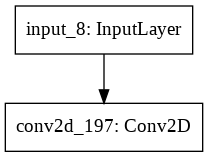

In [18]:
class FeatureExtractorParam(Enum):
    loss_binary_crossentropy = "binary_crossentropy"
    optimizer_rmsprop = "rmsprop"
    feature_extract_layer_first_conv = -7
    
def feature_extractor(d: Model=None, common_path: str=DataParm.common_path.value) -> Model:
    """ 
     Parameters
     ----------
     d: Model
         disdrimination model
     common_path: str
         Set the path to load the model

     Returns
     -------
     intermidiate_model: Model
         Feature extraction model
    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    # Set feature extractor for Discriminator
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[FeatureExtractorParam.feature_extract_layer_first_conv.value].output)
    intermidiate_model.compile(loss=FeatureExtractorParam.loss_binary_crossentropy.value, optimizer=FeatureExtractorParam.optimizer_rmsprop.value)
    return intermidiate_model
  
d_model = discriminator_model()
f_model = feature_extractor(d_model)
f_model.summary()
plot_model(f_model, to_file='f_model.png')

### Anomaly detector


Create a model that generates anomaly scores and images by adjusting the layers that generate noise

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_199 (Activation)  (None, 10)                0         
_________________________________________________________________
model_11 (Model)             (None, 28, 28, 1)         182145    
_________________________________________________________________
model_10 (Model)             (None, 14, 14, 64)        1664      
Total params: 183,919
Trainable params: 1,774
Non-trainable params: 182,145
_________________________________________________________________


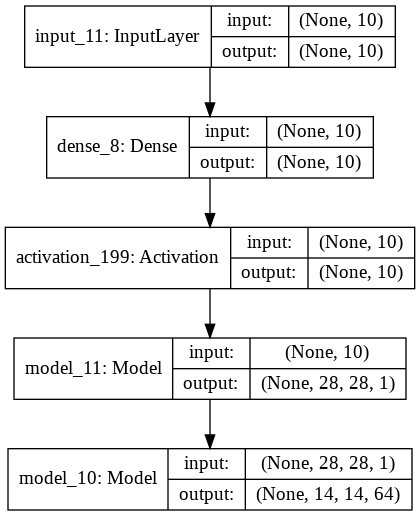

In [19]:
class AnomalyDetectorParam(Enum):
    activation_sigmoid = "sigmoid"
    optimizer_rmsprop = 'rmsprop'
def anomaly_detector(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    
    
     Parameters
     ----------
     g: Model
         Generation model
     d: Model
         Identification model
     in_shape: tuple
         Noise input size
     loss_weights: list
         Set importance of loss

     Returns
     -------
     model: Model
         Model that generates anomaly scores and images

    """
    # Create feature extraction model from Discriminator
    intermidiate_model = feature_extractor(d)
    # Do not learn feature extraction model
    feature_extractor.trainable = False
    # Create Generator
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generator does not learn 
    g.trainable = False
    # layers for learning  Noize
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)
    
    # Generate image with noise input
    G_out = g(gInput)
    # Extract feature from image
    D_out = intermidiate_model(G_out)
    # Create a model that outputs images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)
    
    # Fix BatchNorm to avoid learning
    K.set_learning_phase(0)
    
    return model
  
g_model = generator_model()
d_model = discriminator_model()
a_model = anomaly_detector(g_model, d_model)
a_model.summary()
plot_model(a_model, to_file="anomaly_plot.png", show_shapes=True, show_layer_names=True)

### Anomaly score Computation

In [0]:
def compute_anomaly_score(model: Model, x: np.array, iterations: int=500, d: Model=None, noize_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
     Function to calculate anomaly score
    
     Parameters
     ----------
     g: Model
         Model for calculating anomaly scores
     x: np.array
         Image for verification
     iterations: int
         Set iteration
     d: Model
         discriminator model

     Returns
     -------
     loss: np.asarray
         Abnormal score
     similar_data: np.asarray
         Generate noise by inputting noise into a model with adjusted noise
    """
    # Create noise
    z = np.random.uniform(0, 1, size=noize_shape)
    # create feature extractor model
    intermidiate_model = feature_extractor(d)
    # Extract features of real image
    d_x = intermidiate_model.predict(x)
    # Using noise as an input, learn noise using real images and feature values of real images as targets
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    # Create image from noise
    similar_data, _ = model.predict(z)
    # derive anomalies score
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

-Get learning and test data

-Data scales from -1 to 1

-Use learning data of label 1 for GAN learning.

-Use test data of label 1 and test data of other labels for verification

In [21]:
%%time
batch_size = DataParm.batch_size_64.value
Model_d, Model_g = train(batch_size, X_train)

Eposh is  0


104/105 [============================>.] - ETA: 0s - g: 0.7118 - d: 0.0425WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.9466 - d: 0.0038
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.9784 - d: 0.0011
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.9868 - d: 0.0018
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.9928 - d: 1.7670e-04
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.9898 - d: 9.8628e-04
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.9921 - d: 7.3835e-04
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.9962 - d: 7.0034e-04
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.9977 - d: 5.8244e-05
Eposh is 

Tensorboard for checking te logs

In [0]:
%load_ext tensorboard 

In [23]:
%tensorboard --logdir DataParm.common_path.value

In [0]:
def anomaly_detection(test_img: np.asarray, g: Model, d: Model, iteration: int=200) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
     Function to calculate anomaly score
    
     Parameters
     ----------
     test_img: np.asarray
         Image for verification
     g: Model
         Model for calculating anomaly scores
     d: Model
         Identification model
     iterations: int
         Set iteration

     Returns
     -------
     ano_score: np.asarray
         Abnormal score
     original_x: np.asarray
        Verification image adjusted to 0-255 pixel area
     similiar_x: np.asarray
        An image generated from a model that calculates the anomaly score
     show:
        Difference between verification image and generated image
    """
    # Model to calculate anmalies score
    model = anomaly_detector(g=g, d=d)
    # image shape
    test_img_shape = test_img.shape
    #  Estimate abnormal scores and similar images from test images
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iteration, d=d)
    
    # Derivation of difference between real image and similar image
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4 ###
    
    # Convert to uint8 and multiply by 255. Set to 0-255 pixel area
    np_residual = (255 * np_residual).astype(np.uint8)
    # Set the original image and similar image to 0-255 pixel area as well
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # Convert to GRAY color image
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show

Prepare 7 images as abnormal images

In [0]:
img_index = 14
label_index = 7
test_image = X_test_original[Y_test==label_index][img_index]


Get trained generation and identification models

In [0]:
g, d  = load_models(common_path=DataParm.common_path.value)

Derivation of abnormal scores, verification images, prediction images, and difference images

In [57]:
%%time
start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection(test_image, g=g, d=d, iteration=200)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
#print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

CPU times: user 24.3 s, sys: 376 ms, total: 24.7 s
Wall time: 24.4 s


Since the image of 7 is not learned, the difference between the generated 1 and the image is displayed

anomaly score :  1374.97900390625


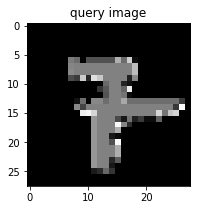

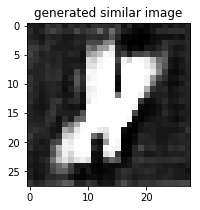

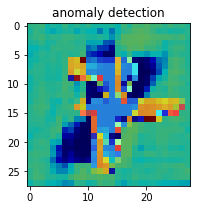

In [28]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

Try to observe the feature space of the noise image, image 1 and other images

random noise image


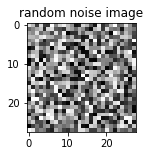

In [29]:
# Create 100 28x28x1 images
random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

Extract features to visualize and check the image.

In [30]:
model = feature_extractor()
# Feature extraction from random images
feature_map_of_random = model.predict(random_image, verbose=1)
# Extract features of images whose labels are not 1
feature_map_mnist = model.predict(X_test_original[Y_test != 1][:300], verbose=1)
# Extract features of image with label 1
feature_map_mnist_1 = model.predict(X_test[:100], verbose=1)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 627

Aggregate features into one piece of data.

In [0]:
# Combine each feature space output earlier
output = np.concatenate((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
# Keep only the first dimension, the other dimensions are synthesized
output = output.reshape(output.shape[0], -1)

Visualize features in a two-dimensional space

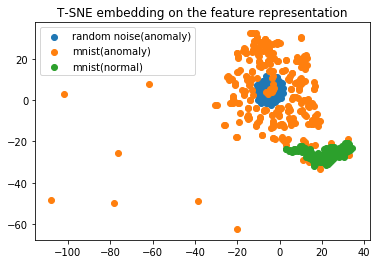

In [32]:
# Compressed in 2 dimensions so that feature space can be visualized
X_embedded = TSNE(n_components = 2).fit_transform(output)
plt.figure(5)
plt.title("T-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100, 0], X_embedded[:100, 1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400, 0], X_embedded[100:400, 1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:, 0], X_embedded[400:, 1], label='mnist(normal)')
plt.legend()
plt.show()

# Change anomaly score calculation

Generate noise by inputting noise into a model with adjusted noise

-Change noise generation to multiple
-Learn Generator

In [33]:
%%time
def anomaly_detector_second(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
     Create a model that generates anomaly scores and images by adjusting the noise generation layer and the generation model
    
     Parameters
     ----------
     g: Model
         Generation model
     d: Model
         Identification model
     in_shape: tuple
         Noise input size
     loss_weights: list
         Set importance of loss

     Returns
     -------
     model: Model
         Model that generates anomaly scores and images
    """
    # Create feature extraction model from Discriminator
    intermidiate_model = feature_extractor(d)
    # Do not learn feature extraction model
    feature_extractor.trainable = False
    # Create Generator
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generator learns
    g.trainable = True
    # Layer for learning Noize
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)
    
    # Generate image with noise input
    G_out = g(gInput)
    # Extract feature from image
    D_out = intermidiate_model(G_out)
    # Create a model that outputs images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)
    
    # Fix BatchNorm to avoid learning
    K.set_learning_phase(0)
    
    return model

  
def compute_anomaly_score_second(model: Model, x: np.array, iterations: int=5, z_num: int=5, d: Model=None, g: Model=None, noize_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
     Function to calculate anomaly score
    
    Parameters
    ----------
    model: Model
        Model for calculating anomaly scores
    x: np.array
        Image for verification
    iterations: int
        Set iteration
    z_num: int
        Set the number of times to generate noise
    d: Model
        Identification model
    g: Model
        Generation model
    noize_shape: tuple
        Set noise dimension

    Returns
    -------
    loss: np.asarray
        Abnormal score
    similar_data: np.asarray
        Generate noise by inputting noise into a model with adjusted noise
    """
    loss_list = []
    similar_data_list = []
    # Keep Generator as an untrained initial state
    initial_g = copy.deepcopy(g)
    
    # Generate multiple noises and average
    for i in range(z_num):
        z = np.random.uniform(0, 1, size=noize_shape)
        # Create feature extraction model
        intermidiate_model = feature_extractor(d)
        # Extract features of real image
        d_x = intermidiate_model.predict(x)
        # Using noise as an input, learn noise using real images and feature values ​​of real images as targets
        loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
        # Create image from noise
        similar_data, _ = model.predict(z)
        # Derive anomaly score
        loss = loss.history['loss'][-1]
        loss_list.append(loss)
        similar_data_list.append(similar_data)
        # Re-set Generator to something you haven't learned
        model = anomaly_detector_second(g=initial_g, d=d)
      
    average_loss = np.average(loss_list)
    average_similar_data = np.average(similar_data_list, axis=0)
    
    return average_loss, average_similar_data
  
  
def anomaly_detection_second(test_img, g=None, d=None, iterations: int=5) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
   Function to calculate anomaly score (Adjusting the Gnerator, adjusting the part that generates noise multiple times)
    
    Parameters
    ----------
    test_img: np.asarray
        Image for verification
    g: Model
        Model for calculating anomaly scores
    d: Model
        Identification model
    iterations: int
        Set iteration

    Returns
    -------
    ano_score: np.asarray
        Abnormal score
    original_x: np.asarray
       Verification image adjusted to 0-255 pixel area
    similiar_x: np.asarray
       An image generated from a model that calculates the anomaly score
    show:
       Difference between verification image and generated image
    """
    # Model to calculate anomaly score
    model = anomaly_detector_second(g=g, d=d)
    # Estimate abnormal scores and similar 
    test_img_shape = test_img.shape
    # Derivation of difference between real image and similar image
    ano_score, similar_img = compute_anomaly_score_second(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iterations, d=d, g=g)
    
    # Derivation of difference between real image and similar image
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4
    
    # Convert to uint8 and multiply by 255. Set to 0-255 pixel area
    np_residual = (255 * np_residual).astype(np.uint8)
    # et the original image and similar image to 0-255 pixel area as well
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # convert to GRAY color image
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show
  
  
g, d  = load_models()
start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_second(test_image, g=g, d=d, iterations=4,)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 1133.20 11320.58ms
CPU times: user 2min 20s, sys: 1.94 s, total: 2min 22s
Wall time: 2min 22s


anomaly score :  1133.201513671875


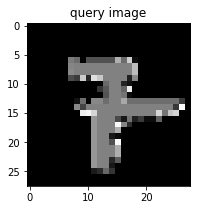

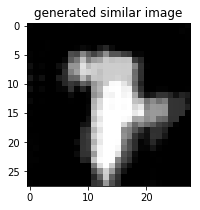

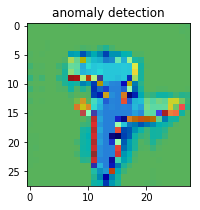

In [34]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# EfficentGAN-BasedAnomalyDetection (F-AnoGAN)






-Implementation of high-speed anomaly detection GAN

## Discrominator

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_395 (Conv2D)             (None, 14, 14, 64)   1088        input_24[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_395[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 64)   0           leaky_re_lu_15[0][0]             
___________________________________________________________________________________________

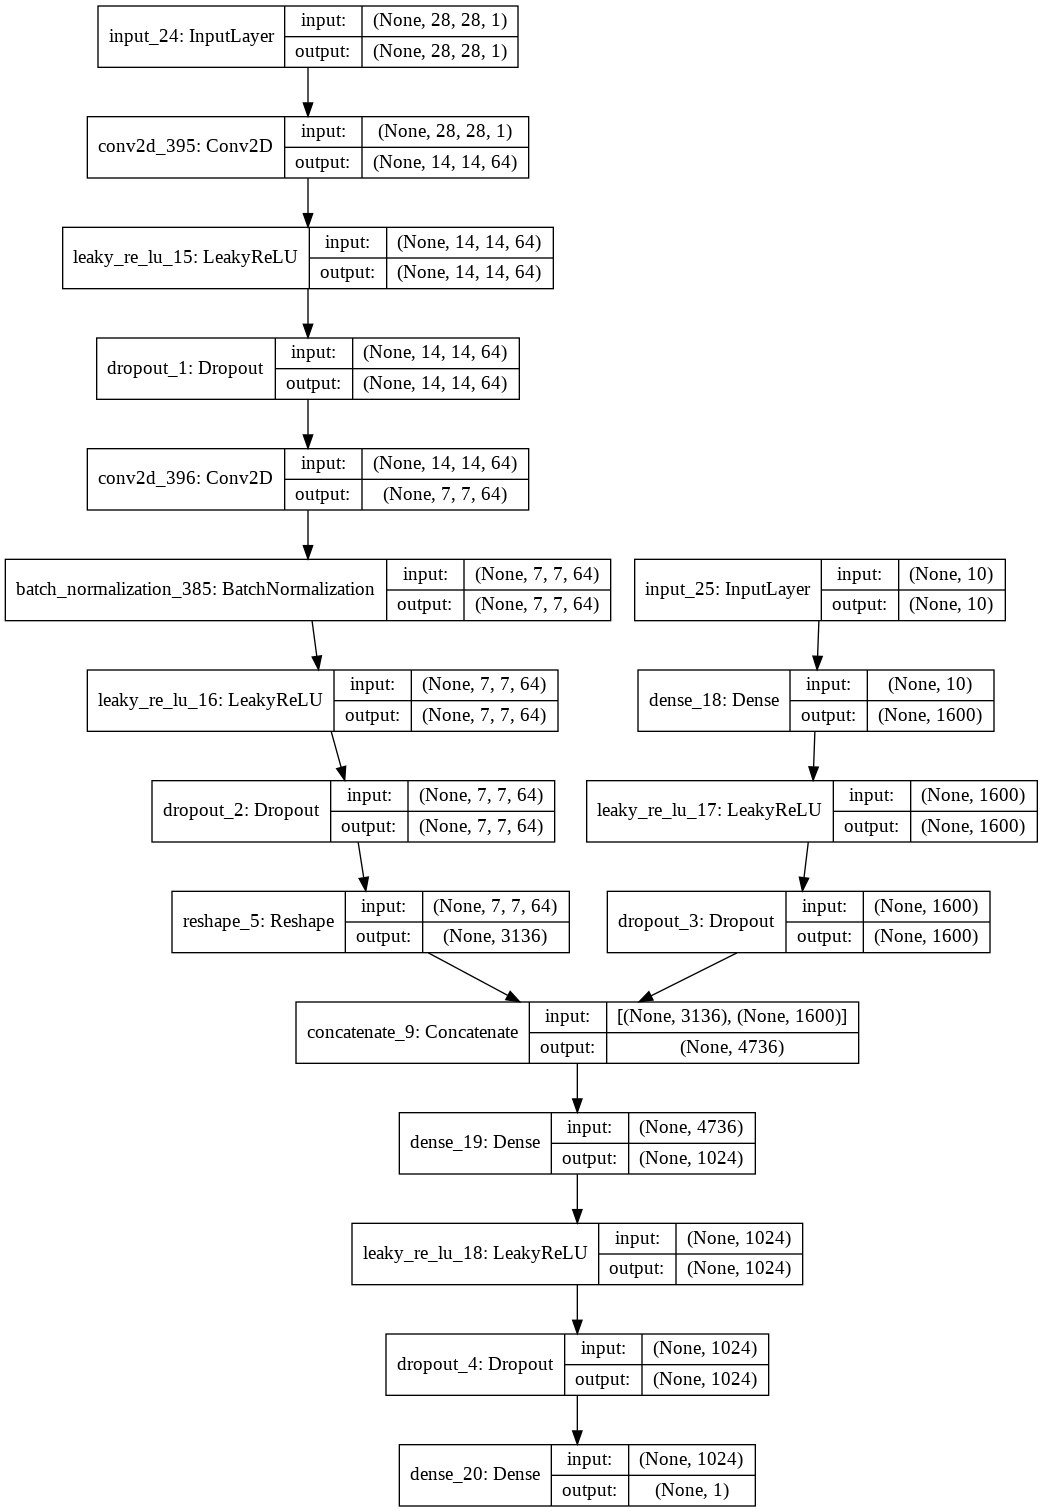

In [35]:
class DiscriminatorEncoderParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_4_4 = (4, 4)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    leaky_relu_param_0_2 = 0.2
    drop_out_0_4 = 0.4
    
    noize_size_5_5_64 = 5 * 5 * 64
    
    leaky_relu_param_0_1 = 0.1
    
    dense_1024 = 1024
    
    out_dense_1 = 1
    out_activation_sigmoid = 'sigmoid'
    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'
    

def define_discriminator(in_shape=(28,28,1), in_z=(10,)) -> Model:
    """
     Creating an identification model
    
    Parameters
    ----------
    in_shape: tuple
        Image dimensions
    in_z: tuple
        Noise dimension
    
    Returns
    -------
    model: Model
        Created identification model (with noise and image as input)
    """
    
    input_x = Input(shape=in_shape)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value, 
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value, 
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value, 
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value, 
               input_shape=in_shape)(input_x)

    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value, 
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value, 
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value, 
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value, 
               input_shape=in_shape)(x)

    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    # Get layer size
    shape_x = K.int_shape(x)
    # Change to 1 dimension so that it can be concated with noise, 0 dimension is not used because it is batch size
    x = Reshape((shape_x[1] * shape_x[2] * shape_x[3],))(x)
    
    # Noise input layer
    input_z = Input(shape=in_z)
    z = Dense(DiscriminatorEncoderParam.noize_size_5_5_64.value)(input_z)
    z = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(z)
    z = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(z)
    
    # Concatenate noise and image extraction part
    concat_x = concatenate([x, z], axis=1)
    x = Dense(DiscriminatorEncoderParam.dense_1024.value)(concat_x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Dense(DiscriminatorEncoderParam.out_dense_1.value, activation=DiscriminatorEncoderParam.out_activation_sigmoid.value)(x)
    
    # Identify using noise and image information
    model = Model(inputs=[input_x, input_z], outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model
  
d_model = define_discriminator()
d_model.summary()
plot_model(d_model, to_file="d_plot.png", show_shapes=True, show_layer_names=True)

## Encode

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_397 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 7, 7, 32)          9248      
_________________________________________________________________
batch_normalization_386 (Bat (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_399 (Conv2D)          (None, 4, 4, 64)          18496     
_________________________________________________________________
batch_normalization_387 (Bat (None, 4, 4, 64)          256

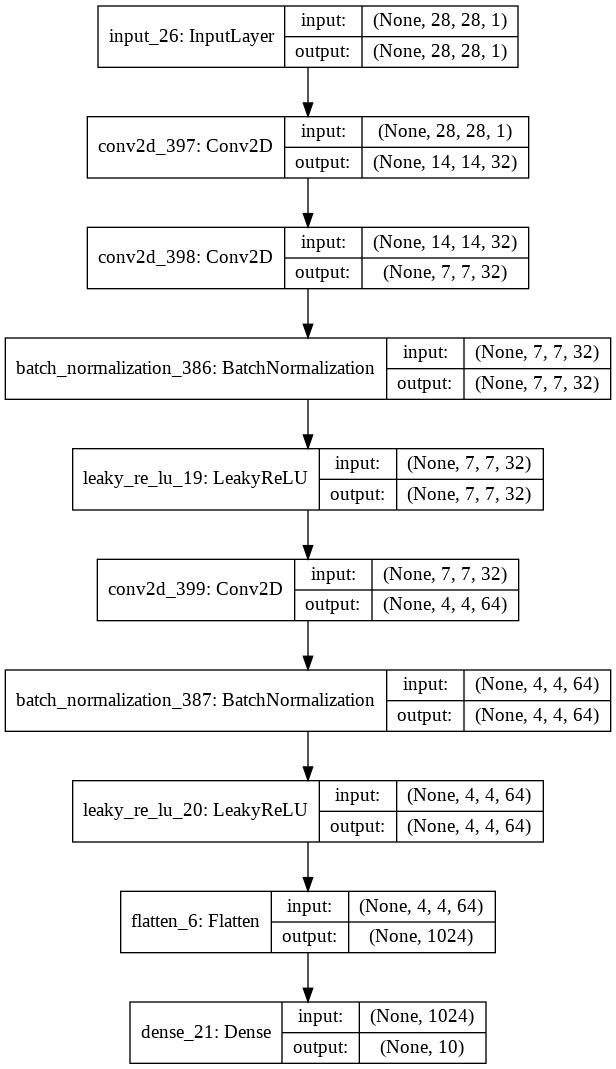

In [36]:
class EncoderParam(Enum):
    con2d_filter_32 = 32
    con2d_kernel_3_3 = (3, 3)
    con2d_strides_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    con2d_filter_64 = 64
    
    leaky_relu_param_0_2 = 0.2
    
    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'
    
def define_encoder(in_shape: tuple=(28, 28, 1), out_z: tuple=(10,)) -> Model:
    """
     Creating an Encoder model
    
    Parameters
    ----------
    in_shape: tuple
        Image dimensions
    out_z: tuple
        Output noise dimensions
    
    Returns
    -------
    model: Model
        Created Encoder model
    """
    input_x = Input(shape=in_shape)
    x = Conv2D(EncoderParam.con2d_filter_32.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(input_x)
    x = Conv2D(EncoderParam.con2d_filter_32.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Conv2D(EncoderParam.con2d_filter_64.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Flatten()(x)
    x = Dense(out_z[0])(x)
    model = Model(inputs=input_x, outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model
  
encoder_model = define_encoder()
encoder_model.summary()
plot_model(encoder_model, to_file="encoder_model_plot.png", show_shapes=True, show_layer_names=True)

## Generator

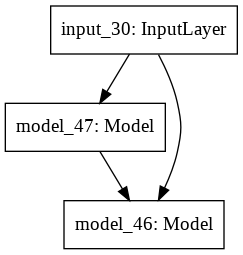

In [37]:
def generator_containint_discriminator(g_model: Model, d_model: Model, in_z: tuple=(10,)) -> Model:
    """
      Creating a mixed model with Discriminator to learn Generator
    
     Parameters
     ----------
     g_model: Model
         Generation model
     d_model: Model
         Identification model
     in_z: tuple
         Dimension of input noise
    
     Returns
     -------
     model: Model
         Mixed model with Discriminator for learning Generator
    """
    d_model.trainable = False
    input_z = Input(shape=in_z)
    x = g_model(input_z)
    
    # Input image and noise
    x = d_model([x, input_z])
    
    gan = Model(inputs=input_z, outputs=x)
    return gan

d_model = define_discriminator()
g_model = generator_model()
g_d_model = generator_containint_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')

## Generate noise from Encoder and identify with Discriminator

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_50 (Model)                (None, 10)           38698       input_34[0][0]                   
__________________________________________________________________________________________________
model_49 (Model)                (None, 1)            4936257     input_34[0][0]                   
                                                                 model_50[1][0]                   
Total params: 4,974,955
Trainable params: 38,506
Non-trainable params: 4,936,449
__________________________________________________________________________________________________


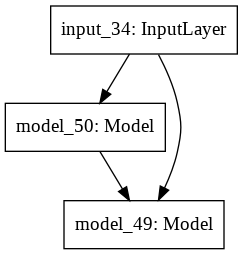

In [38]:
def define_encoder_gan(e_model, d_model, in_shape=(28,28,1)) -> Model:
    """
      Creating a mixed model with Discriminator for learning Encoder
    
     Parameters
     ----------
     e_model: Model
         Encoder model
     d_model: Model
         Identification model
     in_shape: tuple
         Image dimensions
    
     Returns
     -------
     model: Model
         Mixed model with Discriminator for learning Encoder
    """
    d_model.trainable = False
    input_x = Input(shape=in_shape)
    #  Encoder makes image noise
    x = e_model(input_x)
    
    x = d_model([input_x, x])
    
    model = Model(inputs=input_x, outputs=x)
    return model
  
d_model = define_discriminator()
e_model = define_encoder()
gan_encoder_model = define_encoder_gan(e_model, d_model)
gan_encoder_model.summary()
plot_model(gan_encoder_model, to_file='gan_encoder_model.png')

### Learning EfficientAnnoGAN 
In rare cases, the Discriminator may become too strong due to the initial value. In that case, re-learning is necessary

Saving learning logs using Tensorboard is time consuming

In [39]:
class TrainEncoderParam(Enum):
    discriminator_lr = 0.0002
    generator_lr = 0.0002
    encoder_lr = 0.0002
    
    generator_loss = "mse"
    discriminator_generator_loss = "mse"
    discriminator_encoder_loss = "mse"
    discriminator_loss = 'mse'
    
def train_encoder_gan(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str=DataParm.common_path_f_AnoGAN.value) -> Tuple[Model, Model]:
    """
     Learn discrimination and generation models
    
    Parameters
    ----------
    batch_size: int
        Batch size
    X_train: np.ndarray
        Image data for learning
    epoch: int
        Specify number of epochs for learning
    common_path: str
        Specify model and path to save generated image

    Returns
    -------
    d: Model
        Identification model
    g: Model
        Generation model

    """
    d = define_discriminator()
    g = generator_model()
    encoder = define_encoder()
    
    # Mixed model for learning Generator model
    d_on_g = generator_containint_discriminator(g, d)
    
    #  Mixed model for learning Encoder model
    d_on_e = define_encoder_gan(encoder, d)

    # Change to Adam
    d_optim = Adam(lr=TrainEncoderParam.discriminator_lr.value)
    g_optim = Adam(lr=TrainEncoderParam.generator_lr.value)
    e_optim = Adam(lr=TrainEncoderParam.encoder_lr.value)
    
    g.compile(loss=TrainEncoderParam.generator_loss.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainEncoderParam.discriminator_generator_loss.value, optimizer=g_optim)
    d_on_e.compile(loss=TrainEncoderParam.discriminator_encoder_loss.value, optimizer=e_optim)
    
    d.trainable= True
    d.compile(loss=TrainEncoderParam.discriminator_loss.value, optimizer=d_optim)
    
    for e in range(epoch):
        print('Eposh is ', e)
        #  Data size / Batch size = Calculate how many times batch processing is possible with data size
        n_iter = int(X_train.shape[0] / batch_size)
        #Process to make learning progress easy to understand
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # Get 10-dimensional noise for batch size, change to normal distribution for better performance
            noise = np.random.normal(0, 1, size=(batch_size, 10))
            # Get images for batch size
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # Generate image from noise
            generated_images = g.predict(noise, verbose=0)
            # Generate noise from image
            generated_noise = encoder.predict(image_batch, verbose=0)
            
            # Save the generated image for later review
            if index % 20 == 0:
                # Batch size images can be created and converted to a single image
                image = combine_images(generated_images)
                # -1 to 1 scale so convert to 255 scale
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value
                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)  
            # Learning Discriminator
            y = np.array([1] * batch_size)
            d_loss = d.train_on_batch([image_batch, generated_noise], y)
            
            y = np.array([0] * batch_size)
            d_loss = d.train_on_batch([generated_images, noise], y)
            
            # Don't learn Discriminator
            d.trainable = False

            # Learning Generator
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = False
            # Learning Encoder
            e_loss = d_on_e.train_on_batch(image_batch, np.array([0] * batch_size))
            
            d.trainable = True
            
            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss), ('e', e_loss)])
        print('')
        # Create a directory to store the model
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        # Save model
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
        encoder.save(common_path + '/weights/encoder.h5')
    return d, g, encoder

# Fixed random seed for reproducibility
np.random.seed(seed=30)
batch_size = 64
Model_d, Model_g, Model_e = train_encoder_gan(batch_size, X_train)

Eposh is  0
104/105 [============================>.] - ETA: 0s - g: 0.9940 - d: 0.0018 - e: 0.9996
Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.9987 - d: 7.9855e-07 - e: 0.9999
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.9974 - d: 2.8278e-05 - e: 0.9999
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.9983 - d: 1.6906e-05 - e: 1.0000
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.9929 - d: 0.0036 - e: 0.9909
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.9993 - d: 1.0314e-04 - e: 1.0000
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.9981 - d: 3.7950e-05 - e: 0.9999
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.9985 - d: 3.1410e-05 - e: 0.9997
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.9999 - d: 2.6618e-08 - e: 1.0000
Eposh is  9
104/105 [============================>.] - ETA: 0s - g: 0.9996 - d: 5

Because the model includes Encode, change the feature extraction function, abnormal score model creation function, abnormal score derivation function, etc.

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_409 (Conv2D)             (None, 14, 14, 64)   1088        input_35[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_409[0][0]                 
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_32[0][0]             
___________________________________________________________________________________________

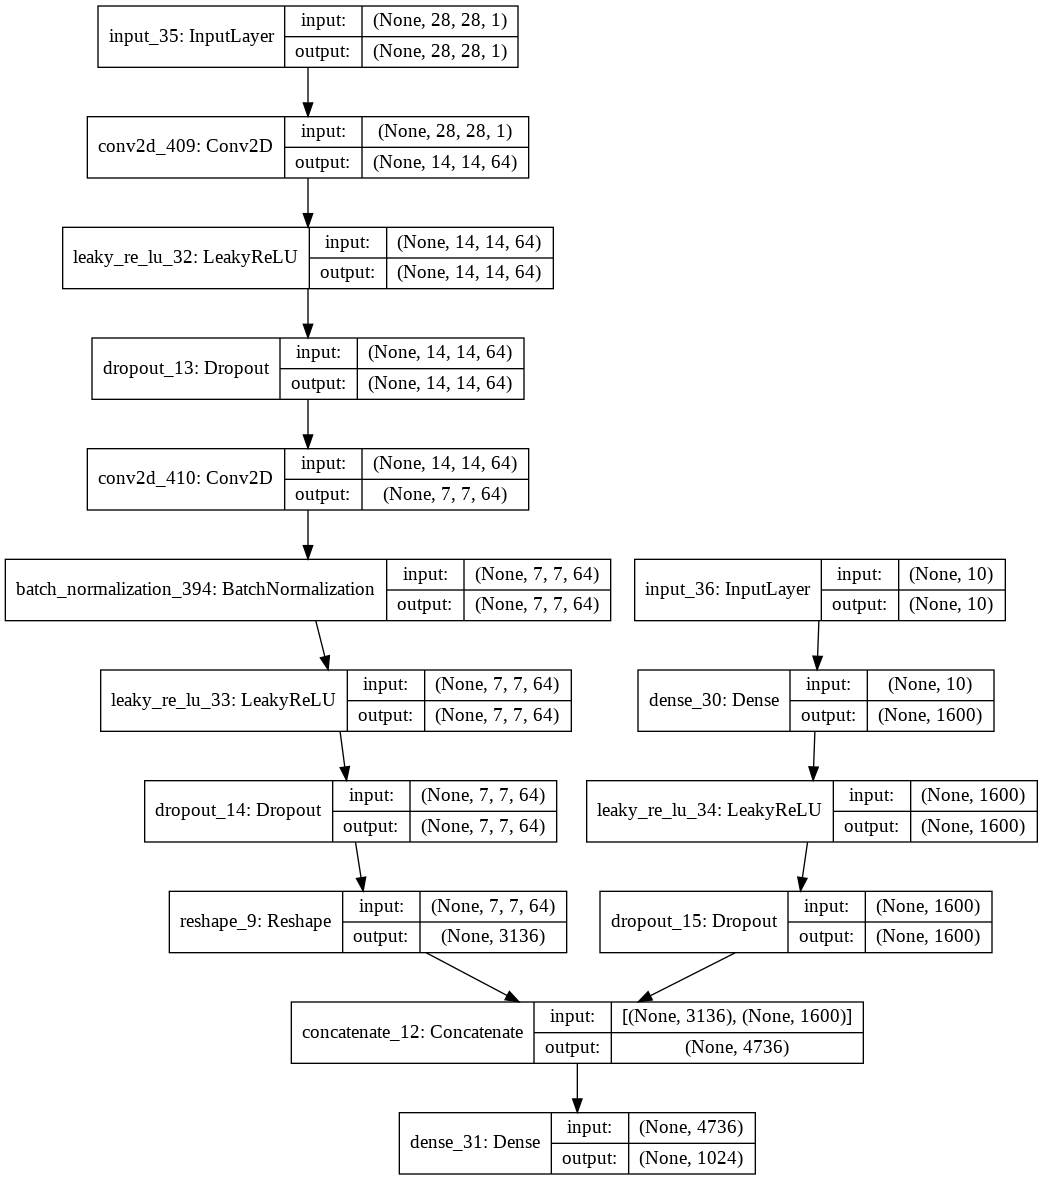

In [40]:
class FeatureExtractorEncodeParam(Enum):
    feature_extractor_loss = 'binary_crossentropy'
    optimizer = 'adam'
    
class AnomalyDetectorEncodeParam(Enum):
    adam = 'adam'
    
def feature_extractor_encode(d: Model=None, common_path: str=DataParm.common_path_f_AnoGAN.value) -> Model:
    """
    Get feature extraction model from identification model
    
    Parameters
    ----------
    d: Model
        Identification model
    common_path: str
        Set the path to load the model

    Returns
    -------
    intermidiate_model: Model
        Feature extraction model


    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    input_layer = []
    # Secure multiple feature layers due to multiple input feature layers
    for index, each_d in enumerate(d.layers):
        if 'input' in each_d.name:
            input_layer.append(each_d.input)
    # Set Discriminator feature extractor
    intermidiate_model = Model(inputs=input_layer, outputs=d.layers[-4].output)
    intermidiate_model.compile(loss=FeatureExtractorEncodeParam.feature_extractor_loss.value, optimizer=FeatureExtractorEncodeParam.optimizer.value)
    return intermidiate_model

feature_extractor_model = feature_extractor_encode()
feature_extractor_model.summary()
plot_model(feature_extractor_model, to_file="feature_extractor_model_plot.png", show_shapes=True, show_layer_names=True)

### Derivation of anomaly score by model including Encoder

In [0]:
def anomaly_detector_encode(g: Model, d: Model, e: Model, img_shape: tuple=(28, 28, 1), loss_weights: list=[0.9, 0.1]) -> Model:
    """
      Create a model that generates anomaly scores and images
    
     Parameters
     ----------
     g: Model
         Generation model
     d: Model
         Identification model
     e: Model
         Encoder model
     img_shape: tuple
         Image input size
     loss_weights: list
         Set importance of loss

     Returns
     -------
     model: Model
         Model that generates anomaly scores and images

    """
    # Create feature extraction model from Discriminator
    intermidiate_model = feature_extractor_encode(d)
    # Do not learn feature extraction models
    intermidiate_model.trainable = False
    # Create Generator
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generator does not learn
    g.trainable = False
    # Encoder does not learn
    e.trainable = False
    # Layer for outputting Noize
    e = Model(inputs=e.layers[1].input, outputs=e.layers[-1].output)
    # Enter image
    aInput = Input(shape=img_shape)

    # Generate noise
    E_out = e(aInput)
    # Generate image with noise input
    G_out = g(E_out)
    # Feature extraction from images
    D_out = intermidiate_model([G_out, E_out])
    # Create models that output images and features
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorEncodeParam.adam.value)
    
    # Fix BatchNorm to avoid learning
    K.set_learning_phase(0)
    
    return model

def compute_anomaly_score_encode(model: Model, intermidiate_model: Model, x: np.array, noise: np.array, d: Model=None, e: Model=None, g: Model=None) -> Tuple[np.asarray, np.asarray,]:
    """
    Parameters
     ----------
     model: Model
         Model for calculating anomaly scores
     intermidiate_model: Model
         A model for extracting features
     x: np.array
         Image for verification
     noise: np.array
         noise
     d: Model
         Identification model
     e: Model
         Encoder model
     g: Model
         Generation model
    
     Returns
     -------
     loss: np.asarray
         Abnormal score
     similar_data: np.asarray
         Generate noise by inputting noise into a model with adjusted noise
    
    """
    # Generate noise
    generate_noise = e.predict(x)

    # Generate image
    generate_image = g.predict(generate_noise)

    # Feature extraction of real images
    target_d_x = intermidiate_model.predict([x, generate_noise])

    # Feature extraction of generated images
    d_x = intermidiate_model.predict([generate_image, noise])

    # Using the generated image as input, evaluate the feature quantity of the actual image, actual image + generated noise
    # loss = model.evaluate(generate_image, [x, target_d_x], batch_size=1, verbose=0)
    # Create image from noise
    similar_data, _ = model.predict(generate_image)
    # Deriving actual image loss using generated image as input
    loss_image = [np.abs(each_x - g_x) for each_x, g_x in zip(x, generate_image)]
    sum_loss_image = np.sum(loss_image)
    # Deriving loss of feature value using feature value as input
    loss_feature = [np.abs(each_d_x - each_g_d_x) for each_d_x, each_g_d_x in zip(target_d_x, d_x)]
    sum_loss_feature = np.sum(loss_feature)

    # Derived abnormal score
    loss = 0.9 * sum_loss_image + 0.1 * sum_loss_feature
    # loss = loss.history['loss'][-1]
    
    return loss, similar_data

def anomaly_detection_encode(test_img, noise, g=None, d=None, e=None, model=None, intermidiate_model=None) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
   Function to calculate anomaly score (Adjusting the Gnerator, adjusting the part that generates noise multiple times)
    
    Parameters
    ----------
    test_img: np.asarray
        Image for verification
    g: Model
        Generation model
    d: Model
        Identification model
    e: Model
        Encoder model
    model: Model
        Model for calculating anomaly scores
    intermidiate_model: Model
        A model for extracting features

    Returns
    -------
    ano_score: np.asarray
        Abnormal score
    original_x: np.asarray
       Verification image adjusted to 0-255 pixel area
    similiar_x: np.asarray
       An image generated from a model that calculates the anomaly score
    show:
       Difference between verification image and generated image
    """
        
    # Get image shape
    test_img_shape = test_img.shape

    # Estimate abnormal scores and similar images from test images
    ano_score, similar_img = compute_anomaly_score_encode(model, intermidiate_model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), noise, d=d, e=e, g=g)

    # Derivation of difference between real image and similar image
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4
    
    # Convert to uint8 and multiply by 255. Set to 0-255 pixel area
    np_residual = (255 * np_residual).astype(np.uint8)
    # Similarly, the original image and similar images should be in the 0-255 pixel area.
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # Convert to GRAY color image
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show

### Get trained model of Generator, Discriminator, Encoder

In [0]:
def load_models_encoder(common_path: str=DataParm.common_path_f_AnoGAN.value) -> Tuple[Model, Model]:
    """
     Load learned generation model, identification model, and Encoder model
    
     Parameters
     ----------
     common_path: str
         Specify path to load model

     Returns
     -------
     g: Model
         Generation model
     d: Model
         Identification model
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    e = load_model(common_path + '/weights/encoder.h5')
    return g, d, e

g, d, e  = load_models_encoder()

### Measure the anomaly detection performance by acquiring the label 7 data

In [0]:
img_index = 14
label_index = 7
test_image = X_test_original[Y_test==label_index][img_index]

### Abnormal score is calculated and an image is generated from the model. Due to the nature of the GPU, the first prediction will be slower

In [0]:
#Model to calculate anomaly score
model = anomaly_detector_encode (g = g, d = d, e = e)
# Create feature extraction model
intermidiate_model = feature_extractor_encode (d)

The first time is slow due to the initialization of the GPU, so the generated model is reused and inferred at high speed.

In [45]:
%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 1306.41 1882.33ms
CPU times: user 18.6 s, sys: 216 ms, total: 18.8 s
Wall time: 18.8 s


In [46]:

%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 1319.09 2.32ms
CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 23.9 ms


Display the input image, the generated image, and the difference between them

anomaly score :  1319.0856201171875


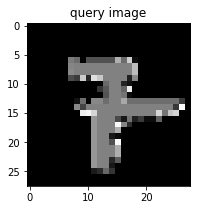

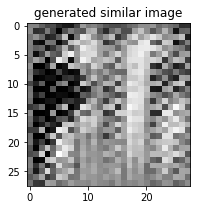

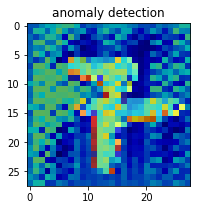

In [47]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28, 28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28, 28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

Measure the anomaly detection performance by acquiring the data of label 1

In [0]:
img_index = 14
label_index = 1
test_image = X_test_original[Y_test==label_index][img_index]

Calculate anomaly scores and generate images from models

In [49]:
noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

1 label, 14 : done 1022.51 3.13ms


Display the input image, the generated image, and the difference between them

anomaly score :  1022.5084045410157


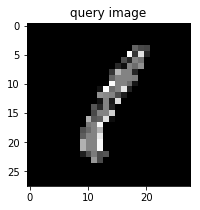

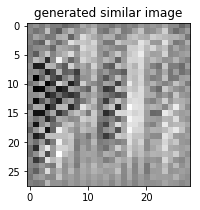

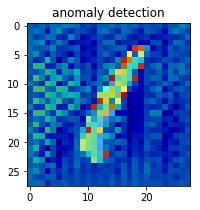

In [50]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

### Try to observe the feature space of the noise image, image 1 and other images

In [51]:
# Create 100 28x28x1 images
random_image = np.random.uniform (0, 1, (100, 28, 28, 1))
random_noise = np.random.uniform (0, 1, (100, 10))

model = feature_extractor_encode ()
# Feature extraction from random images
feature_map_of_random = model.predict ([random_image, random_noise], verbose = 1)

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_409 (Conv2D)             (None, 14, 14, 64)   1088        input_35[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_409[0][0]                 
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_32[0][0]             
___________________________________________________________________________________________

In [0]:
generate_noise_other = e.predict(X_test_original[Y_test != 1][:300])
generate_noise = e.predict(X_test[:100])

100/100 [==============================] - 0s 204us/step
(500, 1024)


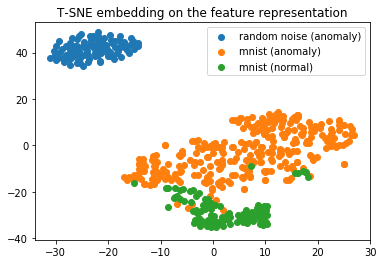

In [53]:
# Extract features of images whose labels are not 1
feature_map_mnist = model.predict ([X_test_original [Y_test != 1] [: 300], generate_noise_other], verbose = 1)
# Extract features of image with label 1
feature_map_mnist_1 = model.predict ([X_test [: 100], generate_noise], verbose = 1)

# Combine each feature space output earlier
output = np.concatenate ((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
print (output.shape)
# Keep only the first dimension, the other dimensions are synthesized
output = output.reshape (output.shape [0], -1)

# Compress to 2D so that feature space can be visualized
X_embedded = TSNE (n_components = 2) .fit_transform (output)
plt.figure (5)
plt.title ("T-SNE embedding on the feature representation")
plt.scatter (X_embedded [: 100, 0], X_embedded [: 100, 1], label = 'random noise (anomaly)')
plt.scatter (X_embedded [100: 400, 0], X_embedded [100: 400, 1], label = 'mnist (anomaly)')
plt.scatter (X_embedded [400 :, 0], X_embedded [400 :, 1], label = 'mnist (normal)')
plt.legend ()
plt.show ()

## Calculate ROC-AUC

Calculate ROC-AUC using the abnormal score of the data of label 1 that is not used for learning and other data

In [0]:
g, d, e = load_models_encoder ()
# Model to calculate anomaly score
model = anomaly_detector_encode (g = g, d = d, e = e)
# Create feature extraction model
intermidiate_model = feature_extractor_encode (d)

ROC-AUC calculation takes about 10 minutes when using TensorBoard

In [55]:
%%time
from sklearn.metrics import roc_curve, auc

label_index = 1
test_image_set = X_test_original[Y_test==label_index]
test_other_image_set = X_test_original[Y_test !=label_index]

noise = np.random.normal(0, 1, size=(1, 10))
anomaly_score_list = []
y_true_list = []

# Calculate anomaly scores for all datasets with label 1 and list
for each_test_image in test_image_set:
    score, query, pred, diff = anomaly_detection_encode(each_test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
    anomaly_score_list.append(score)
    y_true_list.append(0)

# Calculate anomaly scores for all datasets other than label 1 and list
for each_test_image in test_other_image_set:
    score, query, pred, diff = anomaly_detection_encode(each_test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
    anomaly_score_list.append(score)
    y_true_list.append(1)
    
# # Derivation of False Positive Rate and True Positive Rate
fpr, tpr, threshold = roc_curve(y_true_list, anomaly_score_list)
# Calculate AUC value
roc_auc = auc(fpr, tpr)

CPU times: user 4min 16s, sys: 13.6 s, total: 4min 29s
Wall time: 3min 49s


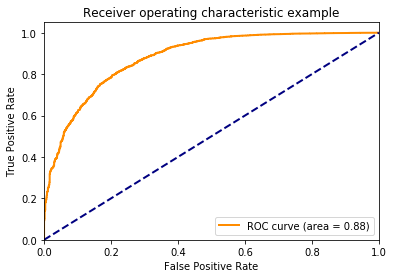

In [56]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()